In [ ]:
from lib import *
import pandas as pd
import matplotlib.pyplot as plt

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

try:
    dfs = load_data_bq()
except Exception as e:
    dfs = load_data_db()
df_contratos = dfs["contract"].sort_values("created_at")
from datetime import timedelta
df_contratos['created_at'] = df_contratos['created_at'].dt.strftime("%Y-%m-%d")
df_contratos["created_at"] = pd.to_datetime(df_contratos["created_at"])
df_contratos["day_of_week"] = df_contratos["created_at"].dt.day_name()
df_contratos["month"] = df_contratos["created_at"].dt.month_name()
df_contratos["day_record_original"] = (df_contratos["created_at"] - df_contratos["created_at"].min()).dt.days

df_contratos_original = df_contratos.copy()
#1m23s

In [2]:
date_range = pd.date_range(start=df_contratos["created_at"].min(), end=df_contratos["created_at"].max(), freq='D')
df_dates = pd.DataFrame(date_range, columns=["date"])
df_dates["date"] = df_dates["date"].dt.strftime("%Y-%m-%d")
df_dates["date"] = pd.to_datetime(df_dates["date"])
df_dates["month"] = df_dates["date"].dt.month_name()
df_dates["day_of_week"] = df_dates["date"].dt.day_name()
df_dates["day_record_prediction"] = (df_dates["date"] - df_contratos["created_at"].min()).dt.days
df_dates = df_dates.merge(df_contratos, left_on=["month", "day_of_week"], right_on=["month", "day_of_week"], how="left")
df_dates["count_by_day"] = df_dates.groupby("date")["date"].transform("count")
#2.9s

In [ ]:
display(df_contratos.head())
display(df_dates.head())

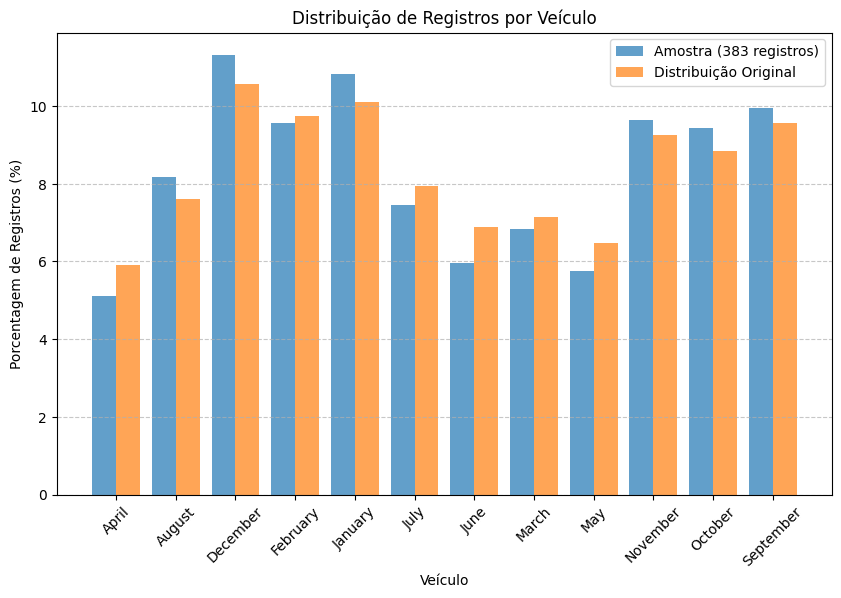

In [48]:
import numpy as np

# Selecionar a coluna a ser analisada
column = "month"

# Amostra aleatória de df_merged_filtered e cálculo das porcentagens
validation_counts_sample = df_dates[column].value_counts(normalize=True) * 100

# Contagem da distribuição original em df
validation_counts_original = df_contratos[column].value_counts(normalize=True) * 100

# Garantir que ambas as distribuições tenham os mesmos índices
categories = sorted(set(validation_counts_sample.index).union(set(validation_counts_original.index)))

# Criar listas de valores alinhados para as categorias
sample_values = [validation_counts_sample.get(cat, 0) for cat in categories]
original_values = [validation_counts_original.get(cat, 0) for cat in categories]

# Criar o gráfico de barras lado a lado
x = np.arange(len(categories))  # Localização das categorias
width = 0.4  # Largura das barras

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, sample_values, width, label="Amostra (383 registros)", alpha=0.7)
plt.bar(x + width/2, original_values, width, label="Distribuição Original", alpha=0.7)

# Personalizar o gráfico
plt.xlabel("Veículo")
plt.ylabel("Porcentagem de Registros (%)")
plt.title("Distribuição de Registros por Veículo")
plt.xticks(x, categories, rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Exibir o gráfico
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Supondo que df_contratos já esteja definido
df = df_contratos.copy()
df = df.groupby("day_record_original")["created_at"].count().reset_index()

# Extrair os valores de x e y
x = df["day_record_original"].values
y = df["created_at"].values

# Aplicar transformação log no eixo y
y_log = np.log(y)

# Realizar regressão linear sobre os dados transformados
coef = np.polyfit(x, y_log, 1)  # coef[0]: inclinação, coef[1]: intercepto
slope, intercept = coef
print(f"Inclinação: {slope}, Intercepto: {intercept}")

# Obter os valores previstos na escala logaritmica
y_log_pred = np.polyval(coef, x)

# Retornar para a escala original aplicando a exponenciação
y_pred = np.exp(y_log_pred)

# Plotar os dados originais e a regressão exponencial
plt.figure(figsize=(8, 5))
plt.scatter(x, y, color="blue", alpha=0.7, label="Dados Originais")
plt.plot(x, y_pred, color="red", linewidth=2, label="Regressão Exponencial")
plt.xlabel("day_record_original")
plt.ylabel("created_at")
plt.title("Regressão Exponencial: Regressão Linear + Exp")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [6]:
x = df_dates["day_record_prediction"]

y_log_pred = np.polyval(coef, x)

# Retornar para a escala original aplicando a exponenciação
y_pred = np.exp(y_log_pred)
df_dates["num_of_contracts_predict"] = y_pred

In [ ]:
df = df_dates.copy()
df["weight"] = 1 / df["count_by_day"] #df_dates["count_by_day"]
display(df.head())

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = df_dates.copy()
df = df.sample(205800)
# df["weight"] = df["num_of_contracts_predict"] / df["count_by_day"] 
df["weight"] =  df["count_by_day"] / 2153 * df["num_of_contracts_predict"] 
display(df.head())

# Gerar o crossplot
plt.figure(figsize=(8, 5))
plt.scatter(df["day_record_prediction"], df["weight"], color="blue", marker="o")
plt.xlabel("Day Record Prediction")
plt.ylabel("Weight")
plt.title("Crossplot: Day Record Prediction vs Weight")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [ ]:
df_dates["count_by_day"].mean()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ----- Código 1: Dados de df_contratos com regressão exponencial -----
# Supondo que df_contratos já esteja definido
df1 = df_contratos.copy()
df1 = df1.groupby("day_record_original")["created_at"].count().reset_index()

# Extrair os valores de x e y para df_contratos
x1 = df1["day_record_original"].values
y1 = df1["created_at"].values

# Transformação log no eixo y para linearizar os dados
y1_log = np.log(y1)

# Regressão linear nos dados transformados
coef1 = np.polyfit(x1, y1_log, 1)  # coef1[0]: inclinação, coef1[1]: intercepto
slope1, intercept1 = coef1
print(f"[df_contratos] Inclinação: {slope1}, Intercepto: {intercept1}")

# Predição na escala log e retorno à escala original (regressão exponencial)
y1_log_pred = np.polyval(coef1, x1)
y1_pred = np.exp(y1_log_pred)

# ----- Código 2: Dados de df_dates com regressão linear -----
df2 = df_dates.copy()
df2 = df2.sample(205800)

# Cálculo da coluna "weight"
df2["weight"] = df2["count_by_day"] / 2153 * df2["num_of_contracts_predict"]
# df2["weight"] = df2["count_by_day"] / 1700 * df2["num_of_contracts_predict"]


# Extrair os valores de x e y para df_dates
x2 = df2["day_record_prediction"].values
y2 = df2["weight"].values

# Regressão linear simples para df_dates
coef2 = np.polyfit(x2, y2, 1)
slope2, intercept2 = coef2
print(f"[df_dates] Inclinação: {slope2}, Intercepto: {intercept2}")

# Para plotar a linha de regressão de forma ordenada, ordenamos os dados de x2
sort_idx = np.argsort(x2)
x2_sorted = x2[sort_idx]
y2_pred = np.polyval(coef2, x2_sorted)

# ----- Plotando ambos os conjuntos de dados e suas regressões no mesmo gráfico -----
plt.figure(figsize=(10, 7))

# Plot para df_contratos
plt.scatter(x1, y1, color="blue", alpha=0.7, label="df_contratos - Dados Originais")
plt.scatter(x2, y2, color="red", alpha=0.5, label="df_dates - Dados")
plt.plot(x1, y1_pred, color="black", linewidth=2, label="df_contratos - Regressão Exponencial")
plt.xlabel("Day Record")
plt.ylabel("Valor")
plt.title("Scatter Plot Combinado com Regressões")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [ ]:
df.groupby("day_of_week")["created_at"].count().reset_index()

In [ ]:
df.sample(383)["count_by_day"].mean()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = df_dates.copy()
df = df.sample(10000)
df["weight"] = df["num_of_contracts_predict"] / df["count_by_day"] 
df["weight"] =  df["count_by_day"] / 2153.501433430515 * df["num_of_contracts_predict"] 


# Agrupar os dados por "day_of_week" e contar os registros em "created_at"
df_grouped = df.groupby("day_of_week")["weight"].sum().reset_index()
df_grouped.columns = ["day_of_week", "sum"]

# Calcular a porcentagem de cada dia da semana
df_grouped["percentage"] = 100 * df_grouped["sum"] / df_grouped["sum"].sum()

# Plotar o gráfico de barras
plt.figure(figsize=(8, 5))
plt.bar(df_grouped["day_of_week"], df_grouped["percentage"], color="blue", alpha=0.7)
plt.xlabel("Dia da Semana")
plt.ylabel("Porcentagem (%)")
plt.title("Porcentagem de 'created_at' por Dia da Semana")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que df_contratos já esteja definido e contenha a coluna "day_of_week"
df1 = df_contratos.copy()

# Agrupar os dados por "day_of_week" e "day_record_original"
df_grouped = df1.groupby(["day_of_week", "day_record_original"])["created_at"].count().reset_index()
df_grouped.columns = ["day_of_week", "day_record_original", "count"]

# Plotar os scatters para cada dia da semana
plt.figure(figsize=(10, 7))
for day in sorted(df_grouped["day_of_week"].unique()):
    subset = df_grouped[df_grouped["day_of_week"] == day]
    plt.scatter(subset["day_record_original"], subset["count"], alpha=0.7, label=f"Dia {day}")

plt.xlabel("day_record_original")
plt.ylabel("Contagem de created_at")
plt.title("Scatter Plot por Day of Week")
plt.legend(title="Day of Week")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [ ]:
df = df_contratos.copy()
df = df.groupby(["day_record_original", "month", "day_of_week"])["created_at"].count().reset_index()
display(df.head())

In [16]:
df_contratos["enum_month"] = df_contratos["created_at"].dt.month
df_contratos["enum_day_of_week"] = df_contratos["created_at"].dt.day_of_week

In [ ]:
df_contratos.head()

/media/tschmitz/hope-keeper/2025/Analise de volume motoristas e contratos versão 2/estudo_volumes_venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 18006.0879 - mae: 87.9336 - val_loss: 19233.8789 - val_mae: 86.8102
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17526.4727 - mae: 86.4360 - val_loss: 19096.2207 - val_mae: 86.6569
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 15488.2422 - mae: 81.2619 - val_loss: 19290.0312 - val_mae: 87.2292
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 16169.3057 - mae: 82.9192 - val_loss: 19252.2480 - val_mae: 87.1150
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 15828.8193 - mae: 81.6498 - val_loss: 19259.0820 - val_mae: 86.9964
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 15851.5742 - mae: 81.6847 - val_loss: 18963.2051 - val_mae: 86.3304
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 14801.7051 - mae: 78.9926 - val_loss: 18344.6309 - val_mae: 84.7995
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 14976.3672 - mae: 77.8415 - val_loss: 17793.3008 - v

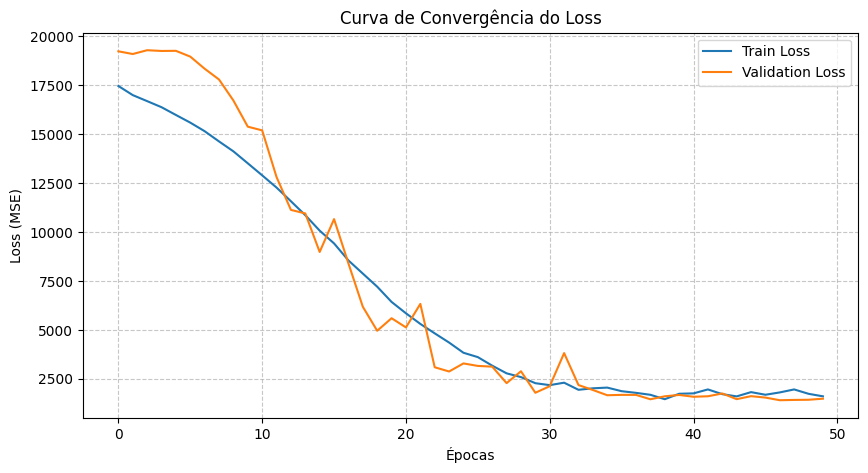

In [73]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Preparar os dados
df = df_contratos.copy()
df = df.groupby(["day_record_original", "enum_month", "enum_day_of_week"])["created_at"].count().reset_index()

# Selecionar features (entradas) e alvo (target)
features = ["day_record_original", "enum_month", "enum_day_of_week"]
X = df[features].values
y = df["created_at"].values

# Normalizar as features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

from tensorflow.keras import layers, models

from tensorflow.keras import layers, models

# Modelo melhorado com Batch Normalization
model = models.Sequential()

# Camada de entrada com mais neurônios, BatchNormalization e ativação 'relu'
model.add(layers.Dense(512, input_shape=(X_train.shape[1],)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

# Camada oculta intermediária com BatchNormalization
model.add(layers.Dense(256))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.2))

# Outra camada oculta para aumentar a capacidade de aprendizado
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Outra camada oculta para aumentar a capacidade de aprendizado
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Outra camada oculta para aumentar a capacidade de aprendizado
model.add(layers.Dense(32))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Camada de saída com ativação linear (padrão para regressão)
model.add(layers.Dense(1, activation='linear'))

# Compilar o modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Treinar o modelo e salvar o histórico
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Avaliar o modelo no conjunto de teste
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f} - Test MAE: {mae:.4f}")

# Fazer previsões
y_pred = model.predict(X_test)
print("Previsões:", y_pred.flatten())

# Plotar a curva de convergência do loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curva de Convergência do Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [67]:
df.head()

,day_record_original,enum_month,enum_day_of_week,created_at,Prediction
0,0,7,2,1,0.743618
1,1,7,3,1,0.441404
2,5,7,0,2,0.934272
3,13,8,1,1,1.054439
4,14,8,2,1,0.900679


54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


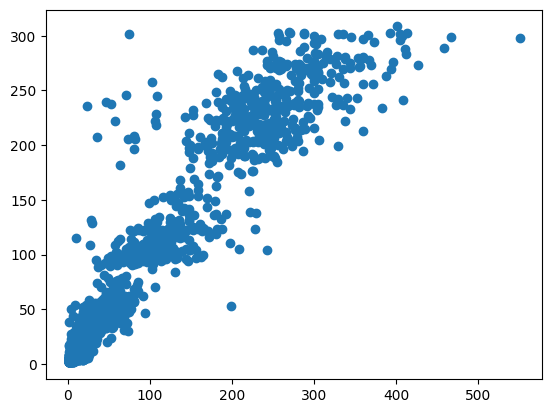

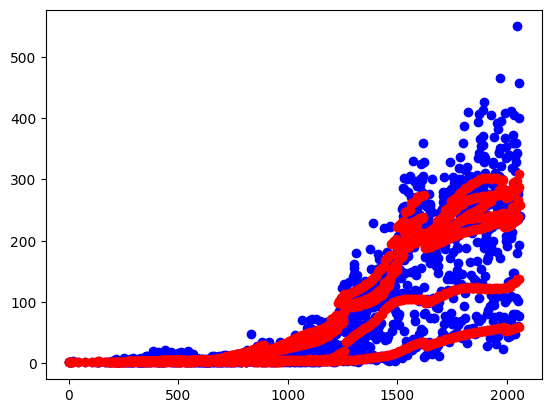

In [74]:
df = df_contratos.copy()
df = df.groupby(["day_record_original", "enum_month", "enum_day_of_week"])["created_at"].count().reset_index()
# df["day_record_original"] = df["day_record_original"] + 10000
# Selecionar features (entradas) e alvo (target)
features = ["day_record_original", "enum_month", "enum_day_of_week"]
X = df[features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y = model.predict(X_scaled)
df["Prediction"] = y

plt.scatter(df["created_at"], df["Prediction"])
plt.show()

plt.scatter(df["day_record_original"], df["created_at"], color="blue")
plt.scatter(df["day_record_original"], df["Prediction"], color="red")
plt.show()
plt.show()
